In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from yellowbrick.cluster import KElbowVisualizer

from scipy import stats 
from scipy.spatial.distance import mahalanobis
from scipy.cluster.hierarchy import dendrogram, fcluster

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Ridge
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import jarque_bera

from pingouin import multivariate_normality

from sample_size_calculation import *
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
data_to_cluster = pd.read_csv("Данные/processed/clustering-data-structure-volume.csv")
data_to_cluster.head()

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",12659741.83,0.34,0.33,0.13,0.06
1,B,Добыча полезных ископаемых,42000380.00,0.07,0.19,0.70,0.03
2,C,Обрабатывающие производства,40131529.33,0.22,0.50,0.23,0.03
3,D,"Обеспечение электрической энергией, газом и па...",29250986.67,0.16,0.34,0.46,0.01
4,E,"Водоснабжение; водоотведение, организация сбор...",5519033.17,0.12,0.11,0.71,0.04


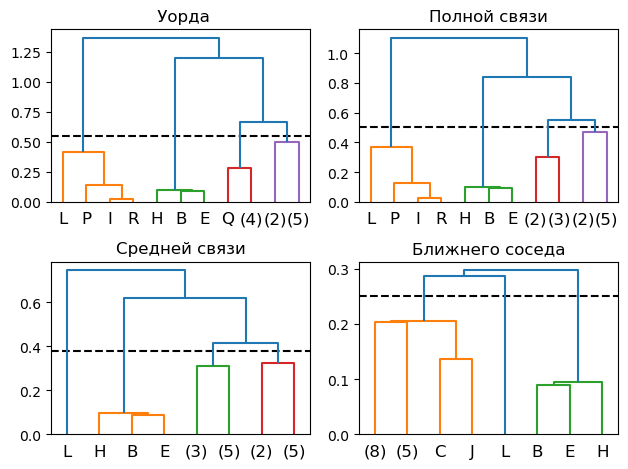

In [71]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

feature_labels_assets = ["Здания", "Машины и оборудование", \
    "Сооружения", "Транспортные средства"]
# feature_labels_assets = ["Здания", "Машины и оборудование", \
#     "Сооружения"]
X = data_to_cluster.loc[:, feature_labels_assets]
# scaler = MinMaxScaler()
# X["Всего основных фондов"] = scaler.fit_transform(X.loc[:, ["Всего основных фондов"]])

linkage_types = ['ward', 'complete', 'average', 'single']
cutoff_thresholds = [0.55, 0.5, 0.38, 0.25]
linkage_colors = dict(zip(linkage_types, cutoff_thresholds))
labels = [' Уорда', 'Полной связи', "Средней связи", "Ближнего соседа"]
linkage_labels = dict(zip(linkage_types, labels))

mpl.rcParams.update(mpl.rcParamsDefault)
hclust = dict()
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for linkage_type, axs_ind in zip(linkage_types, axs_indices):
    model = AgglomerativeClustering(linkage=linkage_type, distance_threshold=0, n_clusters=None)
    clustering = model.fit(X)
    axs[axs_ind].set_title(linkage_labels[linkage_type])
    axs[axs_ind].axhline(y=linkage_colors[linkage_type], linestyle='dashed', color='black')
    linkage_matrix = plot_dendrogram(
        clustering,
        truncate_mode="level",
        p=3,
        ax=axs[axs_ind], 
        labels=data_to_cluster["Код раздела"].to_list(),
        color_threshold = linkage_colors[linkage_type]
        # orientation='right'
        )
    
    hclust[linkage_type] = {
        "clustering": clustering,
        "linkage_matrix": linkage_matrix
    }
fig.tight_layout()
plt.show()


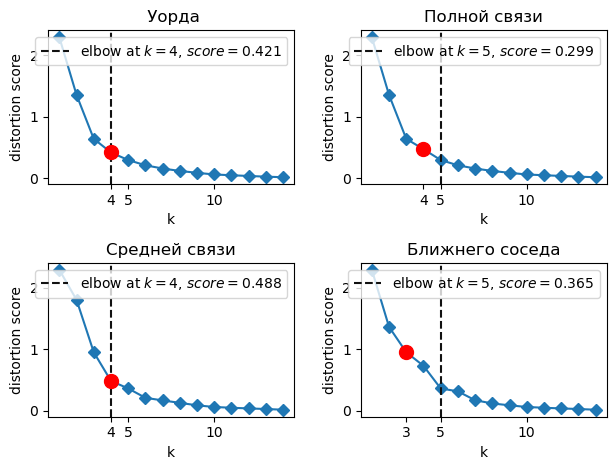

In [72]:
chosen_x = [4., 4., 4., 3.]
chosen_y = [0.421457, 0.475347, 0.487812, 0.953896]
scores = []
fig, axs = plt.subplots(2, 2)
axs_indices = [(i, j) for i in range(2) for j in range(2)]
for i, linkage_type, axs_ind in zip(range(4), linkage_types, axs_indices):
    model = AgglomerativeClustering(linkage=linkage_type)
    visualizer = KElbowVisualizer(
        model,
        k=(1,15),
        ax=axs[axs_ind], 
        timings=False,
        title = linkage_labels[linkage_type],
        locate_elbow=True
        )
    visualizer.fit(X)
    visualizer.finalize()
    ticks = axs[axs_ind].get_xticks()
    ticks = np.append(ticks, chosen_x[i])
    axs[axs_ind].set_xticks(ticks)
    axs[axs_ind].plot([chosen_x[i]], [chosen_y[i]], \
        marker='o', ms=10, c='red')
    # if linkage_type == 'single':
    #     axs[axs_ind].axvline(x=linkage_chosen_k[linkage_type], color='red', \
    #         linestyle='dashdot')
    scores.append(visualizer.k_scores_)
fig.tight_layout()
# print()
plt.show()

In [73]:
df = pd.DataFrame(scores)
df = df.transpose().rename(columns=dict(zip(df.columns, labels)))
df = df.rename(index=dict(zip(df.index, range(1,df.shape[0]))))
pd.set_option('display.precision', 2)
# pd.reset_option('display.precision')
df.head()

,Уорда,Полной связи,Средней связи,Ближнего соседа
1,2.29,2.29,2.29,2.29
2,1.36,1.36,1.81,1.37
3,0.64,0.64,0.95,0.95
4,0.42,0.48,0.49,0.73
5,0.30,0.30,0.37,0.37


In [74]:
cutoff_thresholds = cutoff_thresholds
cluster_mapping = data_to_cluster.loc[:, :"Код раздела"]
# cluster_mapping = data_to_cluster
cluser_count = []
for linkage_type, t in zip(linkage_types, cutoff_thresholds):
    enum = fcluster(hclust[linkage_type]["linkage_matrix"], t=t, criterion='distance')
    model = hclust[linkage_type]["clustering"]
    # hclust[linkage_type]["score"] = metrics.silhouette_score(X, enum, metric='euclidean')
    cluster_mapping[linkage_type] = enum
    cluser_count.append(cluster_mapping.nunique()[linkage_type])
# ind = data_to_cluster[data_to_cluster['Код раздела'].isin(['A','B'])].index
# data_to_cluster = data_to_cluster.drop(ind)
# cluster_mapping.head()
# data_to_cluster.head()
# cluser_count

In [75]:
data_clustered = pd.merge(data_to_cluster, cluster_mapping, 'inner', "Код раздела")
data_clustered.to_csv('Данные/processed/clustering-mapping-structure.csv', index=False) 
data_clustered.head()

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства,ward,complete,average,single
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",12659741.83,0.34,0.33,0.13,0.06,3,4,2,1
1,B,Добыча полезных ископаемых,42000380.00,0.07,0.19,0.70,0.03,2,2,1,3
2,C,Обрабатывающие производства,40131529.33,0.22,0.50,0.23,0.03,4,4,3,1
3,D,"Обеспечение электрической энергией, газом и па...",29250986.67,0.16,0.34,0.46,0.01,4,3,3,1
4,E,"Водоснабжение; водоотведение, организация сбор...",5519033.17,0.12,0.11,0.71,0.04,2,2,1,3


In [76]:
clu_num = 4
pd.reset_option('all')
# pd.set_option('display.max_colwidth', None)
# data_clustered[data_clustered["ward"] == clu_num].loc[:, ["Название раздела"]]
data_clustered[data_clustered["ward"] == clu_num]

,Код раздела,Название раздела,Всего основных фондов,Здания,Машины и оборудование,Сооружения,Транспортные средства,ward,complete,average,single
2,C,Обрабатывающие производства,4.013153e+07,0.216858,0.495025,0.231176,0.029704,4,4,3,1
3,D,"Обеспечение электрической энергией, газом и па...",2.925099e+07,0.156394,0.341688,0.463022,0.011453,4,3,3,1
5,F,Строительство,4.599606e+06,0.204853,0.344712,0.230527,0.167445,4,3,3,1
9,J,Деятельность в области информации и связи,8.944900e+06,0.086265,0.530233,0.228285,0.013576,4,4,3,1
12,M,"Деятельность профессиональная, научная и техни...",1.037023e+07,0.278223,0.284174,0.338788,0.041760,4,3,3,1
13,N,Деятельность административная и сопутствующие ...,4.343473e+06,0.233424,0.221147,0.290589,0.215896,4,3,3,1
14,O,Государственное управление и обеспечение военн...,3.298362e+07,0.282535,0.131329,0.376917,0.049908,4,3,3,1


In [77]:
data_for_regr = pd.read_csv('Данные/processed/regression-data-v0.csv')
feature_labels_douglas = ['ROFA', 'K','L', 't']
data_for_regr.head()

,Код раздела,Название раздела,ROFA,K,L,t
0,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.033481,9966787,1.302680e+08,2017
1,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.030218,11231579,1.416755e+08,2018
2,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.031950,10989834,1.516897e+08,2019
3,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.028979,12137603,1.583287e+08,2020
4,A,"Сельское, лесное хозяйство, охота, рыболовство...",0.024977,13966128,1.770949e+08,2021


In [78]:
X = data_for_regr.loc[:, "ROFA":"t"]
std_arr = X.std().to_numpy()
print(std_arr)
err_rate = 0.1
# delta_arr = X.mean().to_numpy() * err_rate
delta_arr = std_arr / 2.5
N = X.shape[0]
print(N)

sample_sizes = [sample_size_repetitive(0.05, delta, N, std=std) \
    for delta, std in zip(delta_arr, std_arr)]
sample_sizes

[4.11275169e-02 3.94103165e+07 1.48824052e+08 1.71578706e+00]
108


[16.27458538851528, 16.274585388515284, 16.27458538851528, 16.274585388515284]

In [79]:
data_for_regr[[*feature_labels_douglas]].corr()

,ROFA,K,L,t
ROFA,1.000000,-0.325928,0.536362,-0.163188
K,-0.325928,1.000000,0.011132,0.183455
L,0.536362,0.011132,1.000000,0.209950
t,-0.163188,0.183455,0.209950,1.000000


In [80]:
data_to_cluster = pd.read_csv("Данные/processed/regression-data-v0.csv")
data_clustered_full = pd.merge(data_to_cluster, cluster_mapping, 'inner', "Код раздела")
data_clustered_full = data_clustered_full.drop(columns=['Название раздела'])

In [81]:
data_for_regr_cl = pd.merge(data_for_regr, cluster_mapping, 'inner', "Код раздела")
data_for_regr_cl.loc[:, "ROFA":"L"] = data_for_regr_cl.loc[:, "ROFA":"L"].apply(lambda x: np.log(x))
data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})
data_for_regr_cl.to_csv("Данные/processed/regression-data-log-ward-v1.csv",encoding="windows-1251",
                         index=False)
data_for_regr_cl.groupby('ward').count()

,Код раздела,Название раздела,ln_ROFA,ln_K,ln_L,t,complete,average,single
ward,,,,,,,,,
1,24,24,24,24,24,24,24,24,24
2,18,18,18,18,18,18,18,18,18
3,24,24,24,24,24,24,24,24,24
4,42,42,42,42,42,42,42,42,42


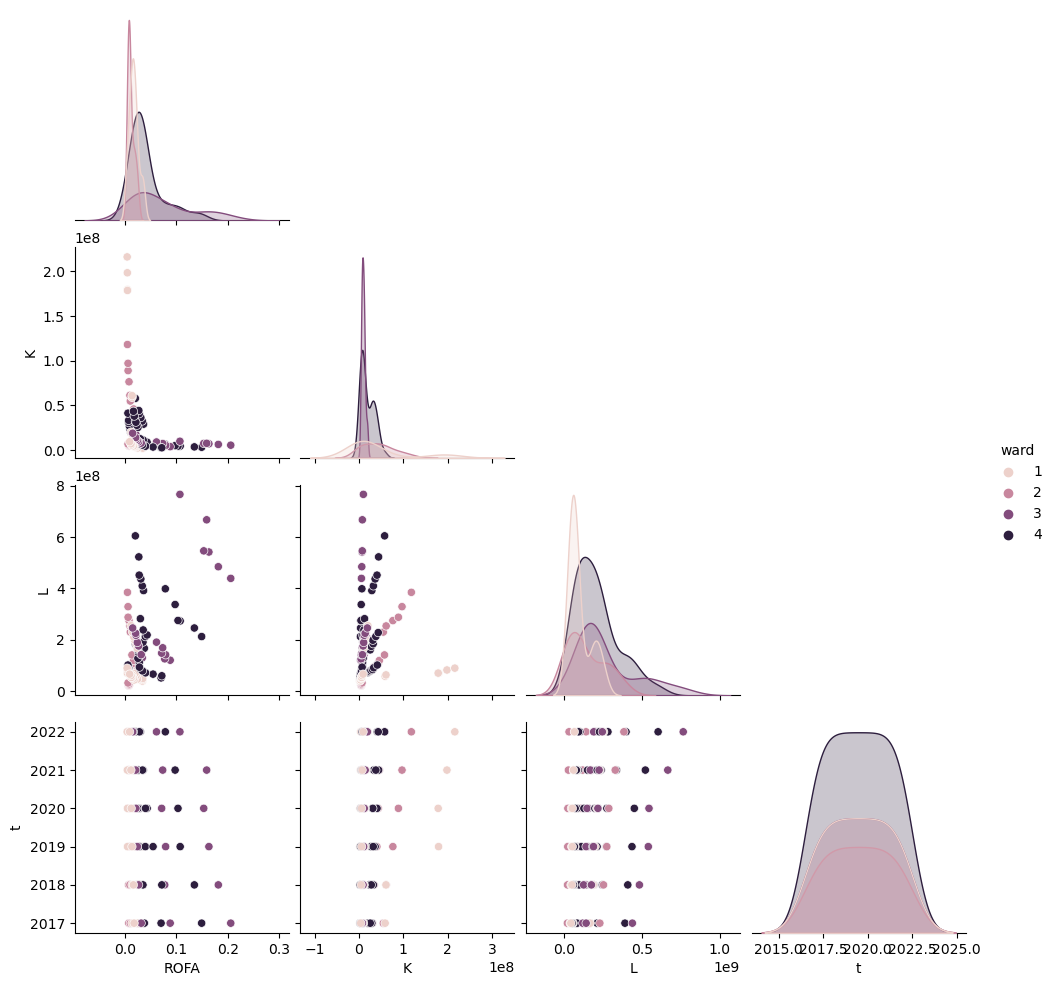

In [82]:
import warnings
warnings.filterwarnings('ignore')
feature_labels_douglas_ln = ['ln_ROFA', 'ln_K', 'ln_L', 't']
sns.pairplot(data_clustered_full.loc[:, ['ward', *feature_labels_douglas]], hue='ward', corner=True)
plt.show()

In [83]:
def get_regr_coef(result_OLS, full=False):
    regr_coef = {}
    regr_coef['coef'] = result_OLS.params
    regr_coef['se'] = result_OLS.bse

    if full:
        regr_coef['t_pvalues'] = stats.t.sf(np.abs(result_OLS.tvalues), result_OLS.df_resid)
        # conf_ints = result_OLS.conf_int(0.05, cols=np.arange(
        #     result_OLS.model.df_model + 1, dtype=np.int64))
        # regr_coef['conf_int_0.05'] = [f'[{row[0]}; {row[1]}]' for row in conf_ints.iterrows()]
        # regr_coef['conf_int_0.95'] = 
    return(regr_coef)

def calc_VIF(regression):
    VIF_dict = {}
    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        VIF_dict[f'VIF_x{exog_idx}'] = round(VIF, 2)
    return VIF_dict

def get_regr_quality(result_OLS):
    regr_quality = {}
    regr_quality['R_sq'] = result_OLS.rsquared
    regr_quality['R_sq_adj'] = result_OLS.rsquared_adj
    # regr_quality['AIC'] = result_OLS.aic
    regr_quality['shapiro-wilk'] = stats.shapiro(result_OLS.resid).pvalue

    # VIF_dict = calc_VIF(result_OLS.model)
    # regr_quality.update(VIF_dict)

    dw = sm.stats.stattools.durbin_watson(result_OLS.resid)
    regr_quality['D-W'] = dw

    white_res = sm.stats.diagnostic.het_white(result_OLS.resid,
                                              result_OLS.model.exog)
    white_lm_pvalue = white_res[1]
    regr_quality['white_pval'] = white_lm_pvalue

    return(regr_quality)

In [84]:
from scipy.stats import wilcoxon
# from help_funcs import _fit_ridge

linkage_type = 'ward'
regr_metrics_all = []
regr_coef_all_dict = {}
regr_quality_all_dict = {}
for cluster_id in data_for_regr_cl[linkage_type].unique():
# for cluster_id in [2]:
    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id]
    data_for_regr_cl[data_for_regr_cl['ward'] == cluster_id]

    regr_metrics = {}
    regr_coef = {}

    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    # if cluster_id == 2:
    #     result_OLS = regression.fit_regularized(alpha=0, L1_wt=0)
    # else:
    result_OLS = regression.fit()

    # def get_coef_restr_OLS(Y, X, a, b):
    #     """
    #     coeff restriction of form a + b = 1
    #     where a, b, c are column labels
    #     """
    #     Y_star = Y.iloc[:, 0] - X[a]
    #     c = f'{b} - {a}'
    #     X_star = X.copy()
    #     X_star[c] = X[b] - X[a]
    #     X_star.drop(columns=[a, b], inplace=True)
    #     coef_restr_OLS = sm.OLS(Y_star, X_star, hasconst=True)
    #     return coef_restr_OLS

    # mod = sm.RecursiveLS(Y, X, constraints='ln_K + ln_L = 1')
    # mod_res = mod.fit()

    # coef_restr_OLS = get_coef_restr_OLS(Y, X, 'ln_K', 'ln_L')
    # coef_restr_OLS_results = coef_restr_OLS.fit()

    regr_coef_all_dict[cluster_id] = pd.DataFrame(get_regr_coef(result_OLS, True))
    regr_quality_all_dict[cluster_id] = get_regr_quality(result_OLS)

    n=X[X.columns[0]].count()
    regr_metrics['cluster_id'] = cluster_id
    regr_metrics['obs_count'] = n

    regr_metrics['shapiro-wilk'] = stats.shapiro(result_OLS.resid).pvalue
    regr_metrics['JB'] = jarque_bera(result_OLS.resid)[1]

    white_res = sm.stats.diagnostic.het_white(result_OLS.resid,
                                              result_OLS.model.exog)
    white_lm_pvalue = white_res[1]
    regr_metrics['white_lm_pvalue'] = white_lm_pvalue

    dw = sm.stats.stattools.durbin_watson(result_OLS.resid)
    regr_metrics['D-W'] = dw

    
    VIF_dict = calc_VIF(regression)
    regr_metrics.update(VIF_dict)
    # print('-- VIF:', VIF_array)
    hz, hz_pval, normal = multivariate_normality(regression.exog)
    regr_metrics['HZ'] = hz_pval
    regr_metrics_all.append(regr_metrics)

    # print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n))
    # print(result_OLS.summary())    
    # print('-- White\'s test pvalue: ', white_lm_pvalue)
    # print('-- VIF:', VIF_dict)
    # print(coef_restr_OLS_results.summary())
    # print('-- VIF:', calc_VIF(coef_restr_OLS))

    # X_resid = X.iloc[:, 1:]
    # X_resid = X_resid.join(pd.DataFrame({"e": result_OLS.resid}))
    # X_resid = X_resid.join(data_for_regr_cl['Код раздела'])
    # g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"], hue='Код раздела', height=4)
    # # g.map(sns.regplot, color=".3", ci=None)
    # g.map(sns.scatterplot)
    # g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])

regr_metrics_all = pd.DataFrame(regr_metrics_all)

# regr_metrics_all[['cluster_id', 'shapiro-wilk']].sort_values(by='cluster_id') \
#     .to_clipboard(float_format='%.2f')
# regr_metrics_all[['cluster_id', 'shapiro-wilk']].sort_values(by='cluster_id') \
#     .style.format('{:.2f}', subset=('shapiro-wilk')).hide()

# regr table (after shuffle)

In [85]:
def get_summary_table(model_code, regr_quality_all_dict,
                    regr_coef_all_dict):
    regr_quality_all = pd.DataFrame(regr_quality_all_dict).transpose()
    regr_quality_all.sort_index()

    regr_coef_all = pd.concat(regr_coef_all_dict, axis=1)
    regr_coef_all = regr_coef_all.rename_axis(columns=['cluster_id', 'indicator'])\
        .sort_index(axis=1,level=0).transpose()
    regr_coef_all.to_clipboard(float_format="%.2f", decimal=',')
    regr_coef_all = regr_coef_all.merge(regr_quality_all, left_on='cluster_id',\
                                        right_index=True)
    regr_coef_all.insert(0, 'model_code', model_code)
    regr_coef_all.set_index('model_code', append=True, inplace=True)
    regr_coef_all = regr_coef_all.swaplevel(1,2)
    return(regr_coef_all)

summary_table_all = get_summary_table(0, regr_quality_all_dict,
                                    regr_coef_all_dict)
summary_table_all.style.format('{:.2f}')

In [86]:
# Check for multivariate normality
group_id = 3
d_clust_g3 = data_clustered_full[data_clustered_full['ward'] == group_id]

print(d_clust_g3.shape)
hz, pval, normal = multivariate_normality(d_clust_g3.loc[:, ['K', 'L', 't']])
print(normal)

(24, 9)
False


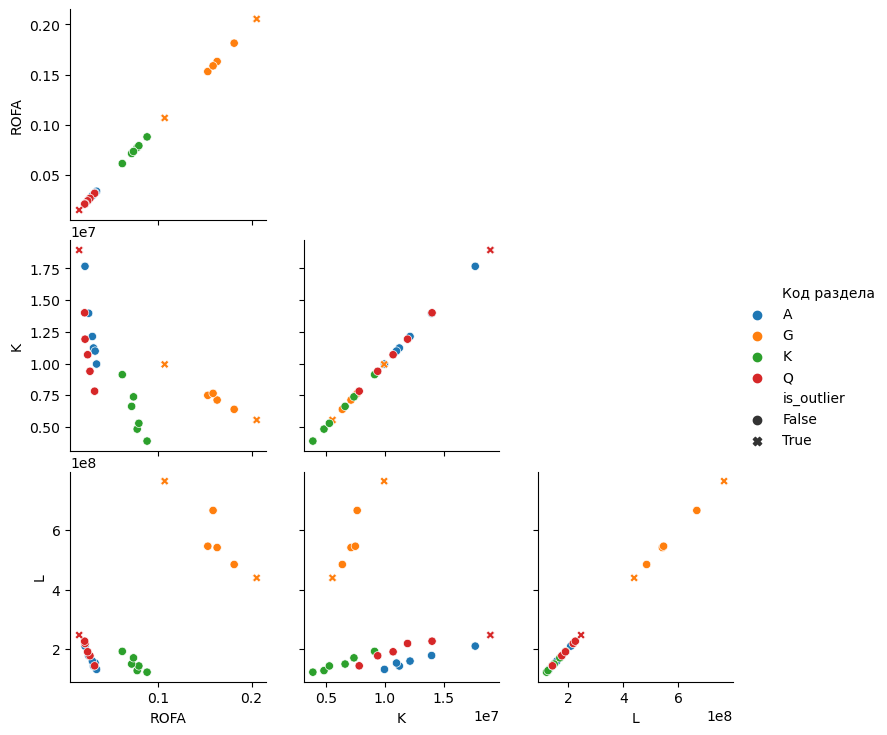

In [87]:
from help_funcs import isMahalanobisOutlier
is_outlier, squared_distances = isMahalanobisOutlier(d_clust_g3.loc[:, ['ROFA', 'K', 'L']]
                                  .to_numpy(), 0.1)
d_clust_g3['is_outlier'] = is_outlier
d_clust_g3['m_dist'] = squared_distances
d_clust_g3.loc[:, [ 'ROFA', 'K', 'L']]

# sns.histplot(d_clust_g3, x='m_dist')
# plt.show()
# sns.boxenplot(d_clust_g3, x='m_dist', k_depth='proportion', outlier_prop=0.5)
# plt.show()
# sns.boxenplot(d_clust_g3, x='m_dist', k_depth='trustworthy', trust_alpha=0.05)

g = sns.PairGrid(data=d_clust_g3.loc[:, ['ROFA', 'K', 'L']], corner=True)
g.map(sns.scatterplot, hue=d_clust_g3['Код раздела'], style=d_clust_g3['is_outlier'], 
      markers={True: 'X', False: 'o'})
g.add_legend()
plt.show()

2.0973209626492692e+18 2.0673740185932882e+18


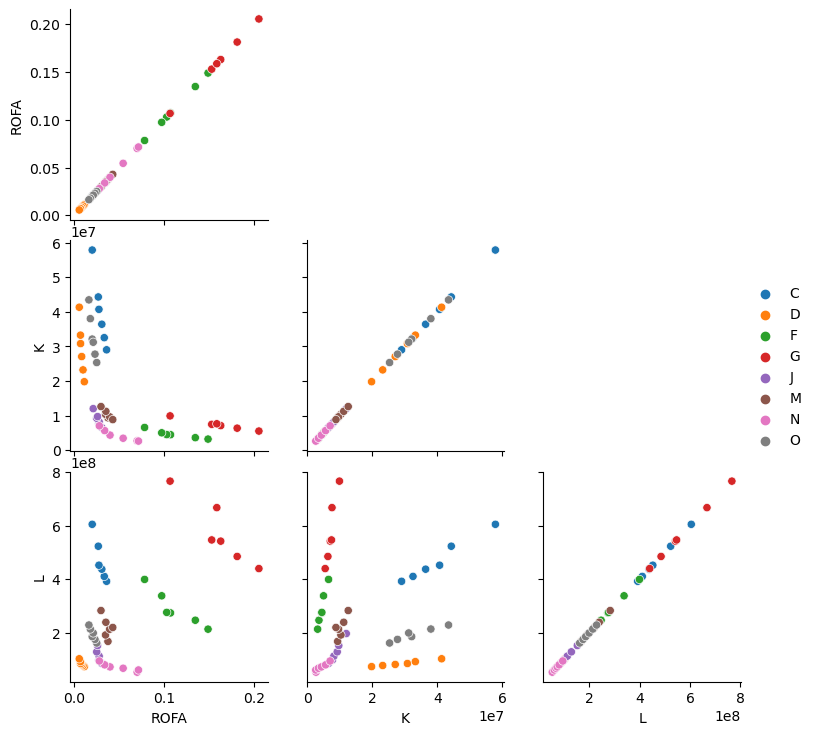

In [88]:
# SHUFFLE OUTLIERS
# Compute distortion first
from yellowbrick.cluster import distortion_score
data_shuffle1 = data_clustered_full.loc[:, ['Код раздела', *feature_labels_douglas, 'ward']].copy()
distortion1 = distortion_score(data_shuffle1[[*feature_labels_douglas]],
                               data_shuffle1['ward'])
data_shuffle2 = data_shuffle1.copy()
data_shuffle2.loc[data_shuffle2['Код раздела'] == 'G', 'ward'] = 4
distortion2 = distortion_score(data_shuffle2[[*feature_labels_douglas]],
                               data_shuffle2['ward'])
print(distortion1, distortion2)

data_shuffle2_cl4 = data_shuffle2[data_shuffle2['ward'] == 4]
g = sns.PairGrid(data=data_shuffle2_cl4.loc[:, ['ROFA', 'K', 'L']], corner=True)
g.map(sns.scatterplot, hue=data_shuffle2_cl4['Код раздела'],
      # style=data_shuffle2_cl4['is_outlier'], 
      markers={True: 'X', False: 'o'})
g.add_legend()
plt.show()

In [89]:
# REMOVE OUTLIERS
dc = data_clustered_full.loc[:, [*feature_labels_douglas, 'ward']].copy()
centroids = dc.groupby('ward').mean()
to_move = data_clustered_full[data_clustered_full["Код раздела"] == 'G'] \
    .loc[:,[*feature_labels_douglas]]
distances = centroids.apply(lambda c: np.linalg.norm(c - to_move.mean()),
    axis='columns')
distances
# cluster_mapping.loc[cluster_mapping['Код раздела'] == 'G', 'ward'] = 1
# cluster_mapping.loc[cluster_mapping['Код раздела'] == 'G', 'ward'] = 3

ward
1    4.782794e+08
2    4.329205e+08
3    3.029430e+08
4    3.662549e+08
dtype: float64

# CORRECT HETEROSCEDASTISITY

In [90]:
from help_funcs import get_whites_regr
import warnings

linkage_type = 'ward'
# data_for_regr_cl = data_shuffle2.copy()
# data_for_regr_cl.loc[:, "ROFA":"L"] = data_for_regr_cl.loc[:, "ROFA":"L"].apply(lambda x: np.log(x))
# data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})
regr_metrics_all = []
# regr_coef_all_dict = {}
# regr_quality_all_dict = {}

for cluster_id in [1, 4]:
    regr_metrics = {}

    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id]
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    result_OLS = regression.fit()


    n=X[X.columns[0]].count()
    for k in range(1, X.shape[1]):
        regr_white_WLS, whites_terms = get_whites_regr(regression, k)
        result_white_WLS = regr_white_WLS.fit()
        print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n))
        print(f'White terms: {whites_terms}')
        print(result_white_WLS.summary())
        white_lm_pvalue = sm.stats.diagnostic.het_white(result_white_WLS.resid, X)[1]
        print('-- White\'s test pvalue: ', white_lm_pvalue)
    
    
    whites_regr, whites_terms = get_whites_regr(regression, full=True)
    result_white_WLS = whites_regr.fit()

    result_OLS = result_white_WLS
    # print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n))
    # print(result_OLS.summary())    
    
    regr_metrics['cluster_id'] = cluster_id
    regr_metrics['obs_count'] = n

    white_lm_pvalue = sm.stats.diagnostic.het_white(result_OLS.resid, X)[1]
    print('-- White\'s test pvalue: ', white_lm_pvalue)
    regr_metrics['white_lm_pvalue'] = white_lm_pvalue

    # SSE_i = (result_OLS.resid ** 2).sum()
    # SSE_all.append(SSE_i)
    # print('-- SSE_i: ', round(SSE_i, 2))  

    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        regr_metrics[f'VIF_x{exog_idx}'] = VIF
    # print('-- VIF:', VIF_array)
    regr_metrics['JB'] = jarque_bera(result_OLS.resid)[1]
    hz, hz_pval, normal = multivariate_normality(regression.exog)
    regr_metrics['HZ'] = hz_pval

    regr_metrics_all.append(regr_metrics)

    # X_resid = X_resid.join(data_for_regr_cl['Код раздела'])
    # g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"],
    #                  hue='Код раздела', height=4)
    # # g.map(sns.regplot, color=".3", ci=None)
    # g.map(sns.scatterplot)
    # g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])

pd.set_option('display.precision', 5)
pd.set_option('display.float_format', '{:,.5f}'.format)
regr_metrics_all = pd.DataFrame(regr_metrics_all)
# print(regr_metrics_all)
regr_metrics_all
# plt.show()


Linkage: ward, cluster 1, n: 24
White terms: ['const', 'ln_L^2']
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            WLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     374.2
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           9.92e-18
Time:                        00:07:02   Log-Likelihood:                 14.339
No. Observations:                  24   AIC:                            -20.68
Df Residuals:                      20   BIC:                            -15.97
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

,cluster_id,obs_count,white_lm_pvalue,VIF_x1,VIF_x2,VIF_x3,JB,HZ
0,1,24,0.02938,1.11226,1.14151,1.08752,0.62933,0.00000
1,4,42,0.00250,1.17717,1.19565,1.09956,0.28271,0.00000


In [91]:
DW_table = [ 
    ( 24, 0.881, 1.407 ),
    ( 18, 0.708, 1.422 ),
    ( 42, 1.15, 1.456 ),
]
DW_table = pd.DataFrame(DW_table, columns=['n', 'DW_L', 'DW_U'])
DW_table['4-DW_U'] = 4 - DW_table['DW_U']
DW_table['4-DW_L'] = 4 - DW_table['DW_L']
DW_table = DW_table.set_index('n', drop=False)
DW_table.loc[24, 'DW_L']

0.881

In [92]:
# CORRECT AUTOREGRESSION
from help_funcs import ols_ar1, OLSAR1
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.graphics.tsaplots import plot_acf

linkage_type = 'ward'
data_for_regr_cl = pd.merge(data_for_regr, cluster_mapping, 'inner', "Код раздела")
data_for_regr_cl.loc[:, "ROFA":"L"] = data_for_regr_cl.loc[:, "ROFA":"L"].apply(lambda x: np.log(x))
data_for_regr_cl = data_for_regr_cl.rename(columns={"ROFA": "ln_ROFA", "K": "ln_K", "L": "ln_L"})
SSE_all = []
# print(data_for_regr_cl[['ln_ROFA', 'ln_K', 'ln_L', 't']].corr())
regr_metrics_all = []
breush_godfrey_all = []
cochrane_log_all = {}
regr_coef_all_dict = {}
regr_coef_all_dict = {}

fig, axes = plt.subplots(2, 2)
fig.tight_layout()
axs_indices = [(i, j) for i in range(2) for j in range(2)]
cluster_ids = np.sort(data_for_regr_cl[linkage_type].unique())
for axs_ind, cluster_id in zip(axs_indices, cluster_ids):
    cluster = data_for_regr_cl[data_for_regr_cl[linkage_type] == cluster_id] \
        # .sort_values('t')

    regr_metrics = {}
    X = cluster.loc[:, ["ln_K", "ln_L", "t"]]
    X = sm.add_constant(X)
    Y = cluster.loc[:, ["ln_ROFA"]]
    regression = sm.OLS(Y, X, hasconst=True)
    result_OLS = regression.fit()

    plot_acf(result_OLS.resid, lags=10, ax=axes[axs_ind])
    axes[axs_ind].set_title(f'Кластер {cluster_id}')

    # RECURSIVE COCHRANE-ORCUTT with P-W fix
    def OLS_AR_n(original_model, max_lag, dw_vals=None, bg_alpha=0.05):
        dw_l, dw_u = dw_vals

        proc_log = {}

        AR_n1 = original_model
        first_lag = 2 + int(original_model.df_model)
        for n_lags in range(0, max_lag+1):
            e_1 = result_OLS.resid[1:].reset_index(drop=True)
            e_0 = result_OLS.resid[:-1].reset_index(drop=True)

            AR_n1_result = AR_n1.fit()
            dw_hat = durbin_watson(AR_n1_result.resid)

            if n_lags > 0:
                bg_result = acorr_breusch_godfrey(original_model.fit(), nlags=n_lags, store=True)
                bg_OLS_result = bg_result[4].resols
                bg_fpvalue = bg_result[3]

                tstat_pvals_all = stats.t.sf(bg_OLS_result.tvalues, bg_OLS_result.df_resid)
                tstat_pval_lag = tstat_pvals_all[first_lag + n_lags - 1]
            else:
                tstat_pval_lag = np.nan
                bg_fpvalue = np.nan

            proc_step_log = {
                # 'n lags' : n_lags,
                'DW-stat' : dw_hat,
                'BG t-stat p-value' : tstat_pval_lag,
                'BG F-stat p-value' : bg_fpvalue,
            }
            proc_log[n_lags] = proc_step_log

            aux_reg = sm.OLS(e_0, e_1)

            result_aux = aux_reg.fit()
            rho = result_aux.params[0]
            final_model = AR_n1
            AR_n0 = ols_ar1(AR_n1, rho)
            AR_n1 = AR_n0
        return(final_model, proc_log)

    n=X[X.columns[0]].count()

    max_lag = 1
    dw_vals = (DW_table.loc[n, 'DW_L'], DW_table.loc[n, 'DW_U'])
    OLS_AR, proc_log = OLS_AR_n(regression, max_lag, dw_vals)
    cochrane_log_all[cluster_id] = pd.DataFrame(proc_log)
    result_OLS = OLS_AR.fit()
    print(result_OLS.summary())
    
    regr_coef_all_dict[cluster_id] = pd.DataFrame(get_regr_coef(result_OLS, True))
    regr_quality_all_dict[cluster_id] = get_regr_quality(result_OLS)

    breush_godfrey = {}
    breush_godfrey['cluster_id'] = cluster_id
    for p in range(1, max_lag+1):
        fpval = sm.stats.diagnostic.acorr_breusch_godfrey(result_OLS, p)[1]
        breush_godfrey[f'p = {p}'] = fpval
    breush_godfrey_all.append(breush_godfrey)

    regr_coef_all_dict[cluster_id] = pd.DataFrame(get_regr_coef(result_OLS, True))
    regr_quality_all_dict[cluster_id] = get_regr_quality(result_OLS)

    regr_metrics['cluster_id'] = cluster_id
    regr_metrics['n'] = n

    white_pvalue = sm.stats.diagnostic.het_white(result_OLS.resid, X)[1]
    regr_metrics['white_pvalue'] = white_pvalue

    regr_metrics['R^2'] = result_OLS.rsquared
    regr_metrics['f_pvalue'] = result_OLS.f_pvalue
    
    VIF_dict = []
    for exog_idx in range(1, regression.exog.shape[1]):
        VIF = variance_inflation_factor(regression.exog, exog_idx)
        VIF_dict.append(round(VIF, 2))
        regr_metrics[f'VIF_x{exog_idx}'] = VIF

    regr_metrics['JB'] = jarque_bera(result_OLS.resid)[1]
    hz, hz_pval, normal = multivariate_normality(regression.exog)

    regr_metrics['HZ'] = hz_pval
    regr_metrics_all.append(regr_metrics)

    dw = sm.stats.stattools.durbin_watson(result_OLS.resid)
    regr_metrics['DW'] = dw

    # print('\nLinkage: {l}, cluster {c}, n: {n}'.format(l=linkage_type, c=cluster_id, n=n))
    # print(result_OLS.summary())    
    # print('-- White\'s test pvalue: ', white_pvalue)
    # print('-- VIF:', VIF_array)

    # X_resid = X.iloc[:, 1:]
    # X_resid = X_resid.join(pd.DataFrame({"e": result_OLS.resid}))
    # X_resid = X_resid.join(data_for_regr_cl['Код раздела'])
    # g = sns.PairGrid(X_resid, y_vars=["e"], x_vars=["ln_K", "ln_L", "t"], hue='Код раздела', height=4)
    # # g.map(sns.regplot, color=".3", ci=None)
    # g.map(sns.scatterplot)
    # g.set(ylim=(-1.5, 1.5), yticks=[-1.5, -1, 0, 1, 1.5])

pd.set_option('display.float_format', lambda x: '%.2f' % x)
breush_godfrey_all = pd.DataFrame(breush_godfrey_all)
regr_metrics_all = pd.DataFrame(regr_metrics_all)
regr_metrics_acorr = pd.DataFrame(regr_metrics_all.loc[:, [ 'cluster_id', 'n', 'DW' ]]) \
    .merge(DW_table.reset_index(drop=True), on='n', how='left')

# cochrane_log_all = pd.DataFrame(cochrane_log_all)
cochrane_log_all = pd.concat(cochrane_log_all, keys=cochrane_log_all.keys())
cochrane_log_all = cochrane_log_all.rename_axis(['cluster_id', 'test'])
cochrane_log_all.sort_values(by='cluster_id').to_clipboard(float_format="%.5f", decimal=',')
# print(regr_metrics_all)

regr_metrics_acorr.sort_values('cluster_id', axis='index'). \
    style.format({
        'DW': '{:.2f}',
        'DW_L': '{:.2f}',
        'DW_U': '{:.2f}',
        '4-DW_U': '{:.2f}',
        '4-DW_L': '{:.2f}',
        }).hide(axis='index')

breush_godfrey_all.sort_values(by='cluster_id', axis='index').style.format('{:.2f}') \
    .format('{:d}', subset=['cluster_id']).hide(axis='index')
cochrane_log_all.sort_values(by='cluster_id')

                            OLS Regression Results                            
Dep. Variable:                ln_ROFA   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     22.00
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           1.52e-06
Time:                        00:07:03   Log-Likelihood:                 2.0953
No. Observations:                  24   AIC:                             3.809
Df Residuals:                      20   BIC:                             8.522
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2208      0.225     -0.981      0.3

0    1
cluster_id test                       
1          DW-stat           0.59 1.80
           BG t-stat p-value  NaN 0.00
           BG F-stat p-value  NaN 0.00
2          DW-stat           1.01 1.31
           BG t-stat p-value  NaN 0.04
           BG F-stat p-value  NaN 0.08
3          DW-stat           0.33 1.65
           BG t-stat p-value  NaN 0.00
           BG F-stat p-value  NaN 0.00
4          DW-stat           0.38 2.17
           BG t-stat p-value  NaN 0.00
           BG F-stat p-value  NaN 0.00

In [93]:
DW_table

,n,DW_L,DW_U,4-DW_U,4-DW_L
n,,,,,
24,24,0.88,1.41,2.59,3.12
18,18,0.71,1.42,2.58,3.29
42,42,1.15,1.46,2.54,2.85


# regr table (non AR)

In [94]:
summary_table_non_ar= get_summary_table(1, regr_quality_all_dict, regr_coef_all_dict)
summary_table_non_ar.style.format('{:.2f}')

In [95]:
summary_table_all

const  ln_K  ln_L     t  R_sq  R_sq_adj  \
cluster_id model_code indicator                                            
1          0          coef      251.07 -0.36  0.26 -0.13  0.89      0.87   
                      se         56.00  0.03  0.08  0.03  0.89      0.87   
                      t_pvalues   0.00  0.00  0.00  0.00  0.89      0.87   
2          0          coef      230.94  1.80 -1.99 -0.11  0.73      0.67   
                      se         83.38  0.32  0.37  0.04  0.73      0.67   
                      t_pvalues   0.01  0.00  0.00  0.01  0.73      0.67   
3          0          coef      -92.02 -1.67  0.78  0.05  0.93      0.92   
                      se         72.64  0.15  0.09  0.04  0.93      0.92   
                      t_pvalues   0.11  0.00  0.00  0.10  0.93      0.92   
4          0          coef      166.27 -0.81  0.79 -0.08  0.95      0.94   
                      se         35.93  0.04  0.05  0.02  0.95      0.94   
                      t_pvalues   0.00  0.00  0.00  0.00  0.95      0.94   

                                 shapiro-wilk  D-W  white_pval  
cluster_id model_code indicator                                 
1          0          coef               0.71 0.59        0.03  
                      se                 0.71 0.59        0.03  
                      t_pvalues          0.71 0.59        0.03  
2          0          coef               0.02 1.01        0.11  
                      se                 0.02 1.01        0.11  
                      t_pvalues          0.02 1.01        0.11  
3          0          coef               0.03 0.33        0.07  
                      se                 0.03 0.33        0.07  
                      t_pvalues          0.03 0.33        0.07  
4          0          coef               0.06 0.38        0.00  
                      se                 0.06 0.38        0.00  
                      t_pvalues          0.06 0.38        0.00

In [96]:
new_summary_table = pd.concat([summary_table_all, summary_table_non_ar])
new_summary_table.sort_index(level=['cluster_id'])
new_summary_table = new_summary_table.sort_index(level=['cluster_id'])
# new_summary_table.to_clipboard(float_format='%.2f')
final_coef = new_summary_table.loc[:, 'const':'t']
final_coef.to_clipboard(float_format='%.2f')
final_coef

const  ln_K  ln_L     t
cluster_id model_code indicator                         
1          0          coef      251.07 -0.36  0.26 -0.13
                      se         56.00  0.03  0.08  0.03
                      t_pvalues   0.00  0.00  0.00  0.00
           1          coef       -0.22 -0.39  0.20 -0.00
                      se          0.22  0.06  0.14  0.00
                      t_pvalues   0.17  0.00  0.08  0.35
2          0          coef      230.94  1.80 -1.99 -0.11
                      se         83.38  0.32  0.37  0.04
                      t_pvalues   0.01  0.00  0.00  0.01
           1          coef       -1.11  0.97 -1.01 -0.00
                      se          0.51  0.50  0.57  0.00
                      t_pvalues   0.02  0.04  0.05  0.38
3          0          coef      -92.02 -1.67  0.78  0.05
                      se         72.64  0.15  0.09  0.04
                      t_pvalues   0.11  0.00  0.00  0.10
           1          coef       -0.07 -1.42  0.86  0.00
                      se          0.08  0.11  0.09  0.00
                      t_pvalues   0.19  0.00  0.00  0.05
4          0          coef      166.27 -0.81  0.79 -0.08
                      se         35.93  0.04  0.05  0.02
                      t_pvalues   0.00  0.00  0.00  0.00
           1          coef       -0.15 -0.99  0.67  0.00
                      se          0.11  0.06  0.06  0.00
                      t_pvalues   0.09  0.00  0.00  0.33

In [97]:
final_quality = new_summary_table.loc[:, 'R_sq':'white_pval'] \
    .droplevel('indicator').drop_duplicates()
final_quality.to_clipboard(float_format='%.2f')
final_quality

R_sq  R_sq_adj  shapiro-wilk  D-W  white_pval
cluster_id model_code                                               
1          0           0.89      0.87          0.71 0.59        0.03
           1           0.77      0.73          0.01 1.80        0.01
2          0           0.73      0.67          0.02 1.01        0.11
           1           0.44      0.32          0.99 1.31        0.25
3          0           0.93      0.92          0.03 0.33        0.07
           1           0.94      0.93          0.00 1.65        0.01
4          0           0.95      0.94          0.06 0.38        0.00
           1           0.91      0.90          0.00 2.17        0.00

In [98]:
d_clust_g2 = data_for_regr_cl[data_for_regr_cl['ward'] == 2][
    ['ln_ROFA', 'ln_K', 'ln_L', 't']]
d_clust_g2.corr()
# sns.heatmap(d_clust_g2.corr(), fmt='.2f', annot=True)
# plt.show()

,ln_ROFA,ln_K,ln_L,t
ln_ROFA,1.00,0.17,0.02,-0.35
ln_K,0.17,1.00,0.98,0.16
ln_L,0.02,0.98,1.00,0.15
t,-0.35,0.16,0.15,1.00


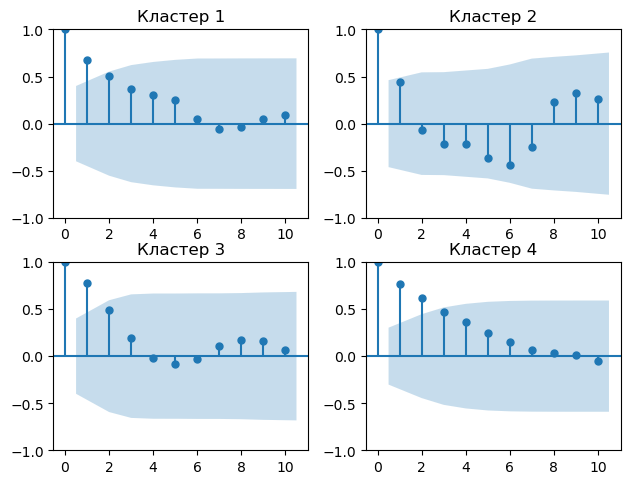

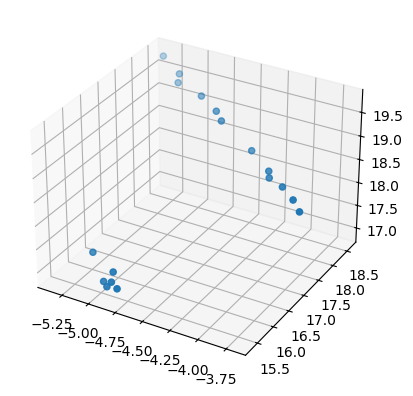

In [99]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(d_clust_g2['ln_ROFA'], d_clust_g2['ln_K'], d_clust_g2['ln_L'])
plt.show()

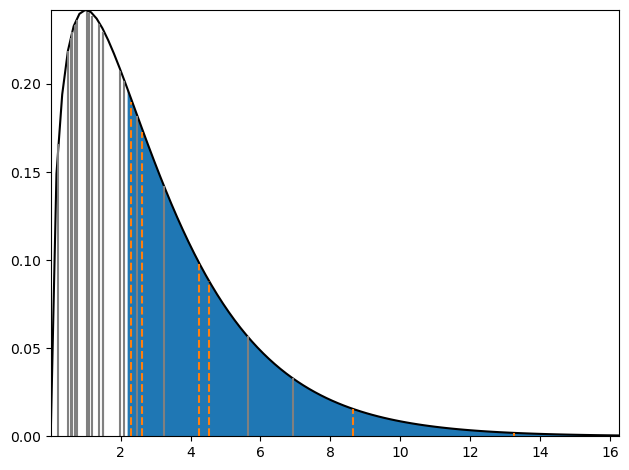

In [100]:
from scipy.stats import chi2
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

fig, ax = plt.subplots(1, 1)
df = 3
x = np.linspace(chi2.ppf(1e-10, df), chi2.ppf(0.999, df), 100)
rv = chi2(df)
d_clust_g3.loc[:, ['is_outlier', 'Код раздела']]
ax.plot(x, rv.pdf(x), c='black')

palette = sns.color_palette(n_colors=d_clust_g3['Код раздела'].nunique())
my_cmap = ListedColormap(palette.as_hex())
codes = d_clust_g3['Код раздела'].unique()
industry_colors = {code: (color if code == 'G' else 'grey') for code, color in zip(codes, my_cmap.colors)}
industry_linestyles = {code: ('dashed' if code == 'G' else 'solid') for code in codes}

# for x, ymax in zip(squared_distances, rv.pdf(squared_distances)):
for idx, obs in d_clust_g3.iterrows():
    ax.axvline(obs['m_dist'], ymax=rv.pdf(obs['m_dist'])*4.1,
               linestyle=industry_linestyles[obs['Код раздела']], c=industry_colors[obs['Код раздела']])

x2 = np.linspace(2.2, chi2.ppf(0.999, df), 80)
ax.fill_between(x2, rv.pdf(x2))
plt.margins(x=0, y=0)
fig.tight_layout()
plt.show()

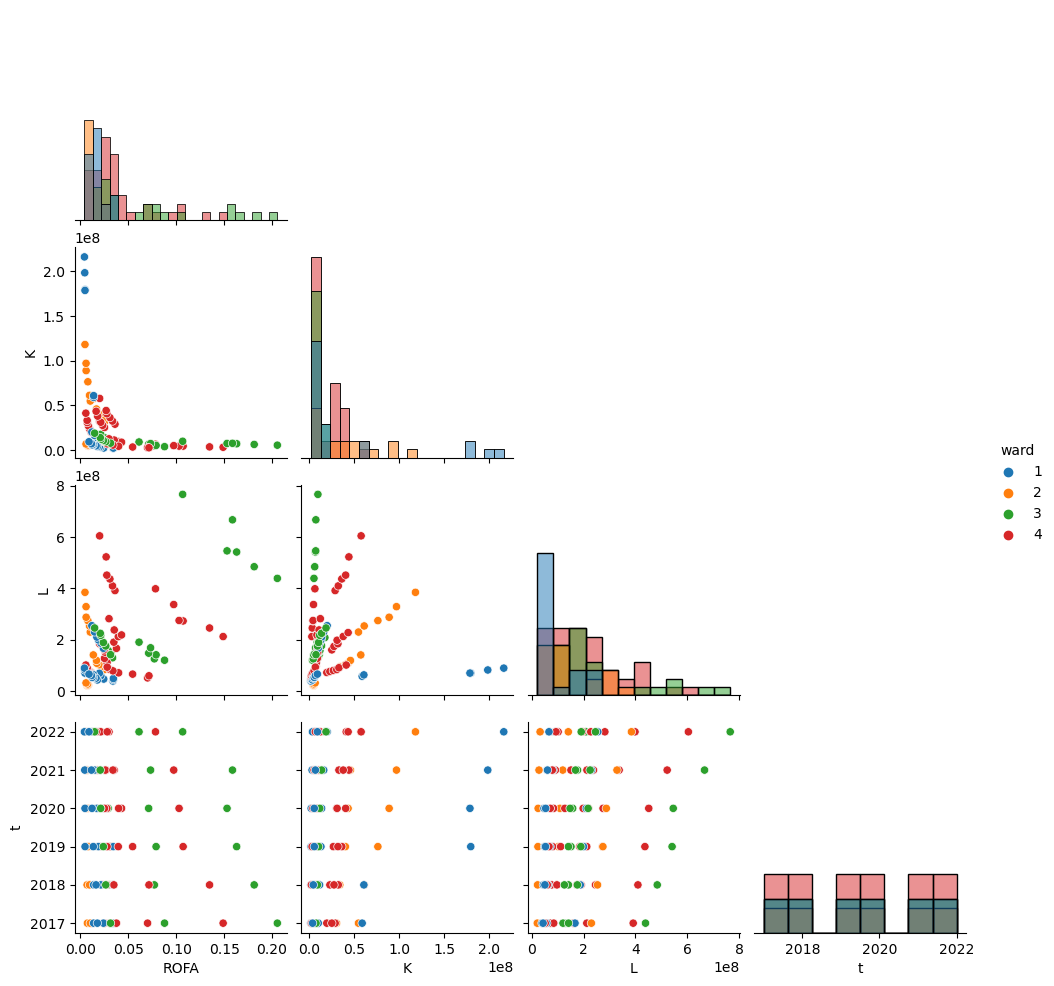

In [101]:
sns.pairplot(data_clustered_full.loc[:, 'ROFA':'ward'],
            corner=True, hue='ward', diag_kind='hist',
            palette=sns.color_palette(n_colors=cluser_count[0]))
plt.show()

In [102]:
data_for_ANOVA = pd.merge(cluster_mapping, data_for_regr.loc[:, ["Код раздела", "ROFA"]], 'inner', 'Код раздела')
for linkage_type in linkage_types:
    groups = []
    for group_id in data_for_ANOVA[linkage_type].unique():
        groups.append(data_for_ANOVA["ROFA"][(data_for_ANOVA[linkage_type] == group_id)].to_numpy())
    res = stats.bartlett(*groups)
    print('bartlett', res.pvalue)
    res = stats.kruskal(*groups)
    print('kruskal', res.pvalue)

bartlett 1.6869756877768281e-21
kruskal 4.093038088584397e-10
bartlett 7.788642596485494e-21
kruskal 9.672797115345697e-10
bartlett 8.065545418041749e-15
kruskal 2.1106469870207733e-08
bartlett 4.920846559604251e-14
kruskal 4.191333764938356e-09
